In [43]:
import numpy as np
import gym
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plot

In [44]:
class Agent:
    def __init__(self, action_space, state_space):
        #hyperparameters, consider adding to constructor
        self.batch_size = 256
        self.learning_rate = 0.001
        self.RB_size = 1000000
        self.gamma = 0.99
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decrement = 1e-4

        self.action_space = np.arange(action_space)

        #Deep Q Network
        self.dqn = DQN(self.learning_rate, action_space, state_space, 16)
        #Replay Buffer
        self.rb = ReplayBuffer(self.RB_size)

    def choose_action(self, state):
        #epsilon probability of taking a random action
        if np.random.random() <= self.epsilon:
            return np.random.choice(self.action_space)
        else:
            state_ = torch.tensor(state).to(self.dqn.device)
            #feed state in tensor form to NN
            actions = self.dqn.forward(state_)
            #return action of the highest output node
            return torch.argmax(actions).item()

    def step(self):
        #prevents learning when batch can not be filled yet
        if len(self.rb) < self.batch_size:
            return

        self.dqn.optim.zero_grad()

        batch = self.rb.get_random_samples(self.batch_size)
        #train NN on every trajectory in batch
        for trajectory in batch:
            trajectory_state = trajectory["state"]
            q_eval = self.dqn.forward(torch.tensor(trajectory_state).to(self.dqn.device))

            trajectory_action = trajectory["action"]

            trajectory_next_state = trajectory["new_state"]
            q_next = self.dqn.forward(torch.tensor(trajectory_next_state).to(self.dqn.device))

            trajectory_reward = trajectory["reward"]

            q_target = trajectory_reward + self.gamma * torch.max(q_next)

            loss = self.dqn.loss(q_target, q_eval[trajectory_action]).to(self.dqn.device)
            loss.backward()

        self.dqn.optim.step()

        self.epsilon = self.epsilon - self.epsilon_decrement if self.epsilon > self.epsilon_min else self.epsilon_min



In [45]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []

    def add_sample(self, current_state, new_state, action, rewards):
        trajectory = {"state": current_state, "new_state": new_state, "action":action, "reward": rewards}
        self.buffer.append(trajectory)

    def sort(self):
        #sort buffer
        self.buffer = sorted(self.buffer, key = lambda i: i["reward"],reverse=True)
        # keep the max buffer size
        self.buffer = self.buffer[:self.max_size]

    def get_random_samples(self, batch_size):
        self.sort()
        idxs = np.random.randint(0, len(self.buffer), batch_size)
        batch = [self.buffer[idx] for idx in idxs]
        return batch

    def get_nbest(self, n):
        self.sort()
        return self.buffer[:n]

    def __len__(self):
        return len(self.buffer)

In [46]:
class DQN(nn.Module):
    def __init__(self, learning_rate, action_space, state_space, hidden_size):
        super(DQN, self).__init__()
        self.actions = np.arange(action_space)
        load_nn = False
        if load_nn:
            self.fc1 = torch.load("fc1.save")
            self.fc2 = torch.load("fc2.save")
            self.fc3 = torch.load("fc3.save")
        else:
            self.fc1 = nn.Linear(state_space, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, action_space)
        self.loss = nn.MSELoss()

        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("Using GPU") if torch.cuda.is_available() else print("Using CPU")
        self.to(self.device)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [47]:
def plot_output(output_array):
    print("Mean reward over", len(output_array), "iterations is", np.mean(output_array))
    avg_per_10 = np.zeros(int(len(output_array)/10))
    for i in range(len(output_array)):
        avg_per_10[i//10] += output_array[i]
    avg_per_10 = avg_per_10 / 10

    avg_per_100 = np.zeros(int(len(output_array)/100))
    for i in range(len(output_array)):
        avg_per_100[i//100] += output_array[i]
    avg_per_100 = avg_per_100 / 100

    plot.figure()
    plot.plot(avg_per_10)
    plot.figure()
    plot.plot(avg_per_100)

In [48]:
def run_for_iterations(envi, iterations):
    final_rewards = []
    agent = Agent(action_space, state_space)

    trunc_counter = 0
    for i in tqdm(range(iterations)):
        states, new_states, actions, rewards = [], [], [], []
        truncated = False
        terminated = False
        observation = envi.reset()
        #envi.reset() returns a tuple with index 0 the state array and index 2 empty
        observation = observation[0]
        while not (truncated or terminated):
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = envi.step(action)
            if truncated:
                trunc_counter += 1
            agent.rb.add_sample(observation, next_observation, action, reward)
            states.append(observation)
            new_states.append(next_observation)
            actions.append(action)
            rewards.append(reward)
            observation = next_observation
        agent.step()
        final_rewards.append(sum(rewards))

    torch.save(agent.dqn.fc1, "fc1.save")
    torch.save(agent.dqn.fc2, "fc2.save")
    torch.save(agent.dqn.fc3, "fc3.save")

    print(final_rewards)

    print("Full Runs", trunc_counter)

    return final_rewards

Using CPU


  0%|          | 0/12000 [00:00<?, ?it/s]C:\Users\mikcl\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 12000/12000 [42:19<00:00,  4.72it/s]


[35.0, 12.0, 23.0, 21.0, 13.0, 35.0, 17.0, 10.0, 28.0, 60.0, 18.0, 15.0, 30.0, 37.0, 32.0, 9.0, 45.0, 29.0, 11.0, 42.0, 41.0, 18.0, 31.0, 23.0, 12.0, 21.0, 11.0, 11.0, 28.0, 11.0, 14.0, 20.0, 20.0, 34.0, 29.0, 14.0, 73.0, 16.0, 59.0, 32.0, 10.0, 13.0, 10.0, 21.0, 24.0, 9.0, 17.0, 22.0, 39.0, 13.0, 35.0, 17.0, 13.0, 26.0, 11.0, 12.0, 11.0, 18.0, 19.0, 17.0, 14.0, 26.0, 24.0, 14.0, 19.0, 11.0, 19.0, 64.0, 13.0, 25.0, 25.0, 23.0, 50.0, 23.0, 44.0, 13.0, 18.0, 14.0, 28.0, 37.0, 14.0, 13.0, 11.0, 26.0, 15.0, 14.0, 22.0, 38.0, 44.0, 16.0, 66.0, 20.0, 17.0, 11.0, 13.0, 35.0, 21.0, 25.0, 18.0, 12.0, 14.0, 13.0, 12.0, 18.0, 11.0, 15.0, 24.0, 38.0, 22.0, 32.0, 28.0, 47.0, 13.0, 54.0, 17.0, 33.0, 20.0, 20.0, 38.0, 57.0, 23.0, 20.0, 19.0, 14.0, 14.0, 9.0, 23.0, 17.0, 22.0, 35.0, 27.0, 30.0, 29.0, 11.0, 15.0, 16.0, 11.0, 11.0, 13.0, 12.0, 17.0, 19.0, 32.0, 24.0, 41.0, 20.0, 93.0, 15.0, 31.0, 20.0, 17.0, 15.0, 20.0, 29.0, 30.0, 17.0, 8.0, 14.0, 36.0, 31.0, 16.0, 15.0, 26.0, 14.0, 19.0, 18.0, 23.0, 4

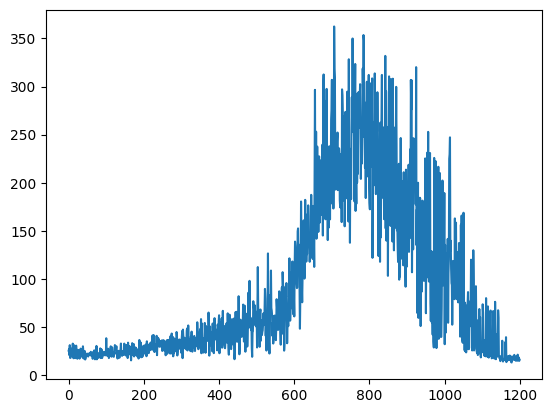

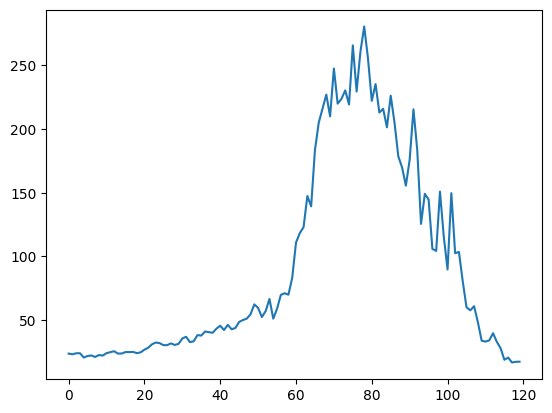

In [49]:
env = gym.make("CartPole-v1")
action_space = env.action_space.n
state_space = env.observation_space.shape[0]

output = run_for_iterations(env, 12000)

plot_output(output)